### Libraries

In [1]:
import sys
sys.path.insert(0, '/app')

import matplotlib.pyplot as plt

from explain_anything.explain import ExA
from explain_anything.seggpt import SegGPT

import os
from PIL import Image
import cv2
import numpy as np
from pathlib import Path

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing
Here, as the different parts are stored in different files, we first want to. For example, for an image of a celebrity `0.jpg`, there would be:
- `0_hair.png`
- `0_l_brow.png`
- `0_r_brow.png`
- ... and so on.

Thus we want to merge this into `0_mask.png` where each integer value represents one unique consecutive pixel value.

In [2]:
anno_dir = Path('/app/examples/classification/data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0')
img_dir = Path('/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/')

Let's give each part a unique number

In [3]:
part_to_idx = {
    'background': 0,
	'skin': 1,
	'nose': 2,
	'eye_g': 3,
	'l_eye': 4,
	'r_eye': 4,
	'l_brow': 5,
	'r_brow': 5,
	'l_ear': 6,
	'r_ear': 6,
	'mouth': 7,
	'u_lip': 8,
	'l_lip': 9,
	'hair': 10,
	'hat': 11,
	'ear_r': 12,
    'neck_l': 13,
    'neck': 14,
	'cloth': 15
}

idx_to_part = ['background', 'skin', 'nose', 'glasses', 'eye', 'brow', 'ear', 'mouth', 'upper lip', 'lower lip', 'hair', 'hat', 'ear_r', 'necklace', 'neck', 'cloth']

Now, we'll go through each part mask and merge them together such that for each image, we will have exactly one mask that contains multiple parts of different integer values.

In [23]:
prev = None
cur_mask = None
count = 0

for i, segment_part_name in enumerate(list(sorted(os.listdir(anno_dir)))):
    segment_img_name = segment_part_name.split('_')[0]
    segment_part = "_".join(segment_part_name.split('_')[1:])
    segment_part = segment_part.split('.')[0]

    img_file_path = anno_dir / Path(segment_part_name)
    img = cv2.imread(str(img_file_path), cv2.IMREAD_GRAYSCALE)
    result = (img == 255).astype(np.uint8) * part_to_idx[segment_part]

    if prev != segment_img_name:
        if cur_mask is not None:
            cur_mask = np.where(cur_mask != 0, cur_mask, result)
            cur_mask = cv2.cvtColor(cur_mask, cv2.COLOR_GRAY2RGB)
            cv2.imwrite(f'/app/examples/classification/masks/{int(segment_img_name) - 1}_mask.png', cur_mask)
            count += 1
            if count == 1000:
                break
        prev = segment_img_name
        cur_mask = result
    else:
        cur_mask = np.where(cur_mask != 0, cur_mask, result)


Let's take a look at this merged mask and plot it out!

Unique values: [ 0  1  2  4  5  7  9 10 14]


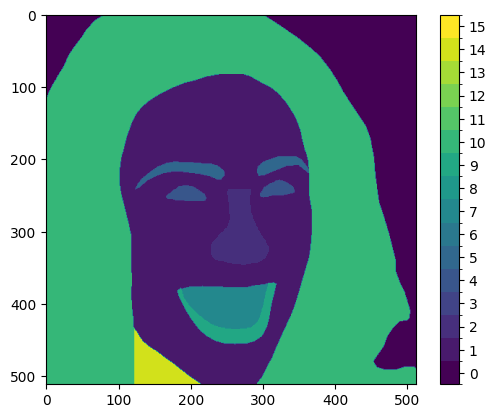

In [40]:
import matplotlib.colors as mcolors

# Define discrete colormap
cmap = plt.cm.get_cmap('viridis', 16)  # 10 discrete colors
bounds = np.arange(-0.5, 16, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.imshow(np.array(Image.open(f"/app/examples/classification/masks/0_mask.png").convert('L')), cmap = cmap, norm = norm)
print("Unique values:", np.unique(np.array(Image.open(f"/app/examples/classification/masks/0_mask.png"))))

# Create a colorbar with integer labels
cbar = plt.colorbar(ticks=np.arange(16)) #list(part_to_idx.keys()))

We see it works great, with each part being assigned a unique integer.

#### Quick Demo of SegGPT
Let's try to perform a very basic SegGPT usecase. Specifically, we'll look at performing few shot segmentation for exactly one part of the body. We'll try the **hair**. To get started, we instantiate the model like below, with the corresponding weight files.

In [16]:
seggpt = SegGPT('/seggpt_vit_large.pth')

[SegGPT] Model Loaded


We'll then provide:
1. the image we want to perform inference on
2. some support images for SegGPT to learn from
3. masks to show SegGPT which part the hair is

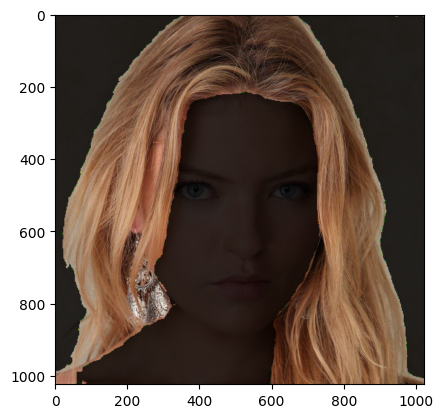

In [74]:
output_mask = seggpt.predict(
    images = 'data/CelebAMask-HQ/CelebA-HQ-img/5.jpg', # We want to select an image that the model has not seen
    support_images = [f'data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg' for i in range(4)],
    support_masks = [f'data/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/0000{i}_hair.png' for i in range(4)],
)

original_image = np.array(Image.open('data/CelebAMask-HQ/CelebA-HQ-img/5.jpg')).astype(float)
output_mask = (output_mask > 1).astype(float) * 0.8 + 0.2
plt.imshow((original_image * output_mask).astype(int))

Next, instead of only the hair, we want to scale it to every single part. We can easily do this by using `FeatureSegmenter`.

In [5]:
from explain_anything.segmenter import FeatureSegmenter

fs = FeatureSegmenter(
	seggpt_checkpoint = '/seggpt_vit_large.pth',
	feature_count = 15
)

[SegGPT] Model Loaded


Let's add some support data for the model to learn from. Note we are adding the merged masks

In [7]:
fs.reset_support_data()

for i in range(11, 21):
	fs.add_support_data(
		f'data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg',
		f'masks/{i}_mask.png',
	)

Now that we have support data in, we can perform segmentation on unseen images!

In [8]:
output_mask = fs.generate_segmentation(
	input_image_path = f'data/CelebAMask-HQ/CelebA-HQ-img/25.jpg'
)

Looking at the results, the model seems to do quite decent.

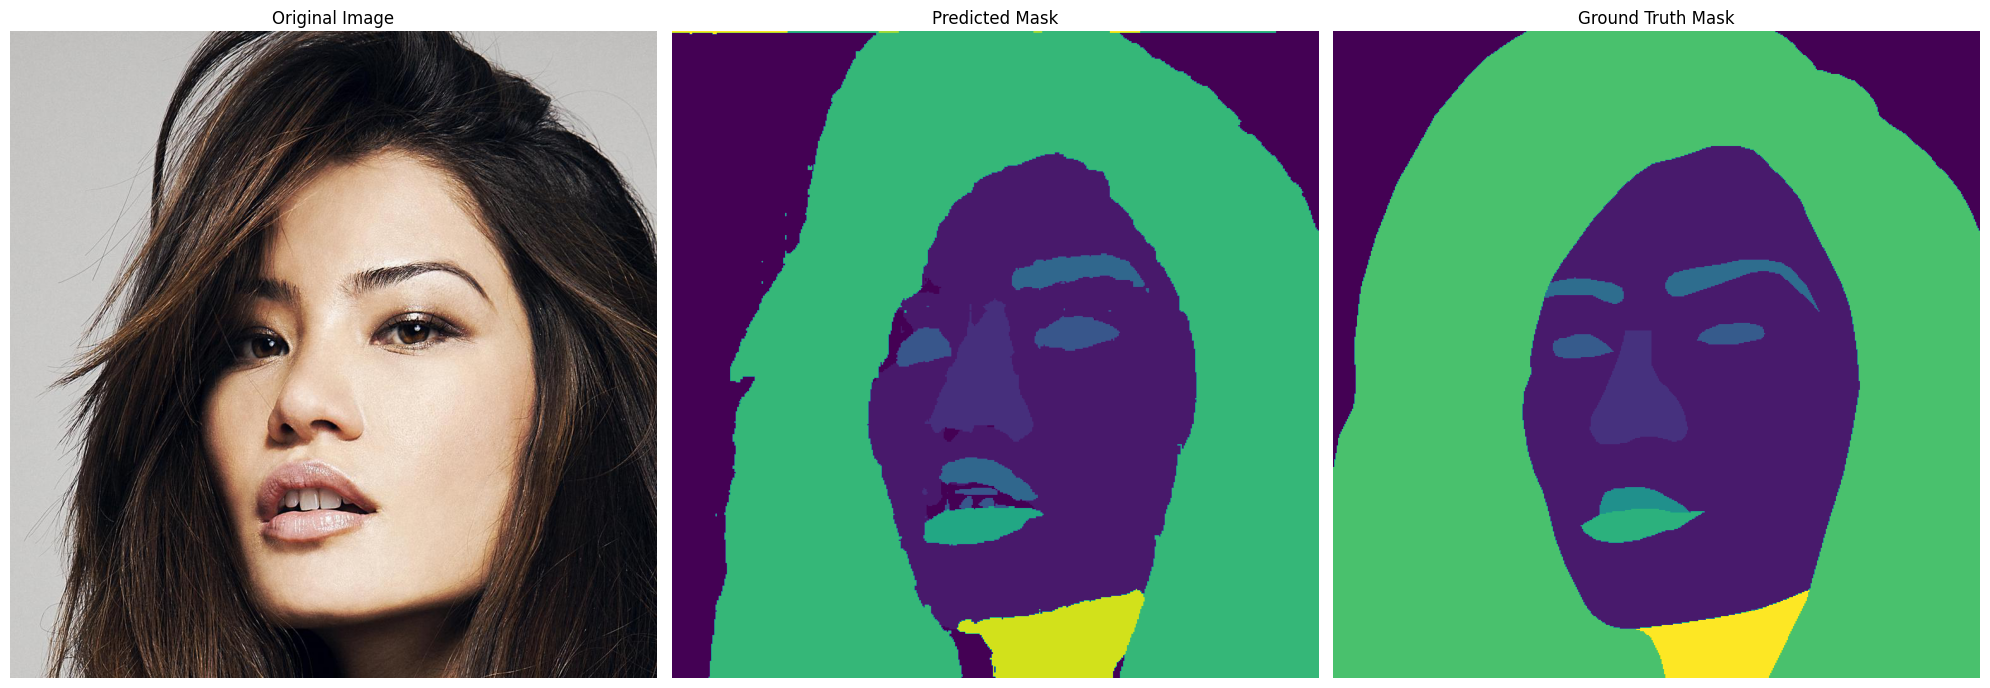

In [10]:
fig = plt.figure(figsize=(20, 40))
ax = fig.subplots(1, 3)

img = np.array(Image.open(f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/25.jpg"))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].set_title("Predicted Mask")
ax[1].imshow(output_mask)
ax[1].axis('off')
ax[2].imshow(Image.open('/app/examples/classification/masks/25_mask.png').convert('L'))
ax[2].axis('off')
ax[2].set_title("Ground Truth Mask")

fig.tight_layout()

We see it works pretty well. We'll apply this to a variety of images and save the masks.

In [13]:
# NOTE: This can be very expensive to run and may take long, as few shot segmentation is being performed
# N x F times, where N is the number of images and F is the number of features.

from tqdm import tqdm

for i in tqdm(range(100, 200)):
	mask = fs.generate_segmentation(
		f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg",
		output_dir = '/app/examples/classification/predicted_masks/'
	)

100%|██████████| 100/100 [10:12<00:00,  6.12s/it]


### Explain Anything
Now that we have the feature masks set up, let's load in a pretrained model that predicts the sex of the celebrity.

In [2]:
import torch
from torchvision.models import resnet50

model = resnet50(weights = None).to('cuda:1')
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features = 2048, out_features = 1, bias = True),
    torch.nn.Sigmoid()
)

checkpoint = 'RN50_best_acc_checkpoint.pkl'
state_dict = torch.load(checkpoint)
model.load_state_dict(state_dict)

<All keys matched successfully>

We will now perform feature ablation

In [3]:
from torchvision.transforms import InterpolationMode
from torchvision import transforms

exa = ExA()
features = ['skin', 'nose', 'glasses', 'eye', 'brow', 'ear', 'mouth', 'upper lip', 'lower lip', 'hair', 'hat', 'ear_r', 'necklace', 'neck', 'cloth']

Let's take a look at the scores attributed to each of the features

In [4]:
def custom_baseline(mask_batch_shape):
	return torch.tensor(np.full(mask_batch_shape, 0)).int().cuda()

Predicted Results:

In [5]:
scores = exa.ablate(
    model,
	[f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg" for i in range(100, 200)],
	'/app/examples/classification/predicted_masks',
    features,
	batch_size = 8,
	num_workers = 0,
    custom_baseline = custom_baseline
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:54<00:00,  1.82it/s]

skin 0.12959647290470613
hair 0.12555855738927
background 0.10641633914172949
cloth 0.08334122112849442
nose 0.07249413813149075
lower lip 0.06412469523548463
neck 0.06101124567850343
eye 0.05931459735747428
brow 0.059054987507181855
glasses 0.0469423745516165
ear 0.04603529607386224
necklace 0.03703598567134004
mouth 0.03492894846576807
upper lip 0.027330139736423106
hat 0.024520092844866764
ear_r 0.022294908181788222


Ground Truth Results:

In [8]:
exa = ExA()

scores = exa.ablate(
    model,
	[f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg" for i in range(100, 200)],
	[f"/app/examples/classification/masks/{i}_mask.png" for i in range(100, 200)],
    features,
	batch_size = 8,
	num_workers = 0,
    custom_baseline = custom_baseline
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]

skin 0.1359693372945394
hair 0.11724189731739541
background 0.10371099546352315
glasses 0.08002812487710492
cloth 0.0785327240430307
neck 0.06408577740226036
nose 0.0637786695557227
hat 0.06113671111684456
lower lip 0.05022806981510929
brow 0.04857455208485211
eye 0.0447313510996826
ear 0.04181688020966297
mouth 0.03620098735982026
ear_r 0.030929460464543077
upper lip 0.02863372454847503
necklace 0.014400737347433376


#### Pretrained ResNet 50
We'll see how a ResNet50 that started it's training process being initialized with ImageNet pretrained weights differ.

In [9]:
import torch
from torchvision.models import resnet50
from torchvision.transforms import InterpolationMode
from torchvision import transforms

model = resnet50(weights = None).to('cuda:1')
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features = 2048, out_features = 1, bias = True),
    torch.nn.Sigmoid()
)

checkpoint = 'RN50_pretrained_best_acc_checkpoint.pkl'
state_dict = torch.load(checkpoint)
model.load_state_dict(state_dict)

exa = ExA()

Predicted Results:

In [13]:
scores = exa.ablate(
    model,
	[f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg" for i in range(100, 200)],
	'/app/examples/classification/predicted_masks',
    features,
	batch_size = 8,
	num_workers = 0,
    custom_baseline = custom_baseline
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]

skin 0.1742858299594024
eye 0.10499876933472564
cloth 0.10300730870681667
hair 0.10227189788214262
lower lip 0.07441014193665636
background 0.07357119666855182
neck 0.05399186309570624
nose 0.05076579788021516
brow 0.0466728584392498
glasses 0.04073939135312486
ear 0.03600466764796606
upper lip 0.03230402032669133
necklace 0.030323459359896714
mouth 0.029001642293335836
ear_r 0.023899710085522136
hat 0.023751445029996467


Ground Truth Results:

In [14]:
exa = ExA()

scores = exa.ablate(
    model,
	[f"/app/examples/classification/data/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg" for i in range(100, 200)],
	[f"/app/examples/classification/masks/{i}_mask.png" for i in range(100, 200)],
    features,
	batch_size = 8,
	num_workers = 0,
    custom_baseline = custom_baseline
)

for s, f in list(sorted(zip(scores, ['background'] + features)))[::-1]:
    print(f, s)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]

skin 0.15940639329275466
hat 0.15149654257292533
glasses 0.09718743041824496
hair 0.08996970133641695
background 0.06107952033483463
nose 0.05788141782041292
eye 0.05302718164189627
cloth 0.04992653815086815
lower lip 0.04984994562784111
brow 0.046943038963984794
neck 0.03877514807463797
mouth 0.03696729948402788
ear 0.033963232275477616
upper lip 0.03085529504234003
ear_r 0.021598658497165475
necklace 0.021072656466171378
